In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/datasethdsj.zip' -d '/content/drive/MyDrive/'

Archive:  /content/drive/MyDrive/datasethdsj.zip
replace /content/drive/MyDrive/dataset-resized/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
!pip3 install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [4]:
import torch
torch.cuda.is_available()

True

In [5]:
"""Headers"""
import os
import os.path as osp
import time

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

from torchvision import datasets

In [6]:
import os.path as osp
import os

import matplotlib.pyplot as plt
import matplotlib

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

from __future__ import print_function
from PIL import Image
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import math

from skimage.transform import resize
import scipy


np.random.seed(111)
torch.cuda.manual_seed_all(111)
torch.manual_seed(111)


class Dataset_Gary(Dataset):

	def __init__(self, root, fold="train",
				 transform=None, target_transform=None):

		fold = fold.lower()

		self.train = False
		self.test = False
		self.val = False

		if fold == "train":
			self.train = True
		elif fold == "test":
			self.test = True
		elif fold == "val":
			self.val = True
		else:
			raise RuntimeError("Not train-val-test")


		self.root = os.path.expanduser(root)
		self.transform = transform
		self.target_transform = target_transform

		fpath = self.root

		# now load the picked numpy arrays
		self.data = []
		if self.train:
			self.datalist_dir = os.path.join(self.root, 'train_list.txt')
		if self.val:
			self.datalist_dir = os.path.join(self.root, 'val_list.txt')
		if self.test:
			self.datalist_dir = os.path.join(self.root, 'test_list.txt')

		with open(self.datalist_dir, 'r') as f:
			for line in f:
				if line[0] == '#' or len(line.strip()) == 0:
					continue
				params = line.strip().split()
				self.data.append({
					'file_name' : params[0],
					'label' : params[1],})

	def __getitem__(self, index):
		label = self.data[index]['label']
		if label == 'cardboard':
			target = 0
		if label == 'glass':
			target = 1
		if label == 'metal':
			target = 2
		if label == 'paper':
			target = 3
		if label == 'plastic':
			target = 4
		if label == 'trash':
			target = 5
		img = plt.imread(osp.join(self.root, self.data[index]['label'], self.data[index]['file_name']))

		# doing this so that it is consistent with all other datasets
		# to return a PIL Image
		img = Image.fromarray(img)

		if self.transform is not None:
			img = self.transform(img)

		if self.target_transform is not None:
			target = self.target_transform(target)

		return img, target

	def __len__(self):
		return len(self.data)



In [7]:
class PreTrainedResNet(nn.Module):
  def __init__(self, num_classes, feature_extracting):
    super(PreTrainedResNet, self).__init__()

    self.resnet18 = models.resnet18(pretrained=True)

    if feature_extracting:
      for param in self.resnet18.parameters():
          param.requires_grad = False

    num_feats = self.resnet18.fc.in_features

    self.resnet18.fc =  nn.Linear(num_feats,num_classes)

  def forward(self, x):
    x = self.resnet18.forward(x)
    return x


In [8]:
def train(model, optimizer, criterion, epoch, num_epochs):
  model.train()
  epoch_loss = 0.0
  epoch_acc = 0.0

  for batch_idx, (images, labels) in enumerate(dataloaders['train']):
    optimizer.zero_grad()

    images, labels = images.cuda(), labels.cuda()

    outputs = model.forward(images)

    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs.data, 1)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += torch.sum(preds == labels).item()

  epoch_loss /= dataset_sizes['train']
  epoch_acc /= dataset_sizes['train']

  print('TRAINING Epoch %d/%d Loss %.4f Accuracy %.4f' % (epoch, num_epochs, epoch_loss, epoch_acc))

  return epoch_loss, epoch_acc


In [9]:
import sklearn.metrics as metric

def test(model, criterion, repeats=2):
  model.eval()

  test_loss = 0.0
  test_acc = 0.0
  f1_score = 0.0
  f1_score_w = 0.0
  conf_mat = np.zeros([len(class_names),len(class_names)])
  with torch.no_grad():
    for itr in range(repeats):
      for batch_idx, (images, labels) in enumerate(dataloaders['test']):
        #move to GPU
        images, labels = images.cuda(), labels.cuda()

        #forward
        outputs = model.forward(images)
        _, preds = torch.max(outputs.data, 1)

        predlabels = preds.cpu().numpy()
        labels_num = labels.cpu().numpy()
        for ind,label in enumerate(labels_num):
          conf_mat[label,predlabels[ind]] = conf_mat[label,predlabels[ind]] + 1


        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)

        test_loss += loss.item()
        test_acc += torch.sum(preds == labels).item()

        f1_score += metric.f1_score(labels_num, predlabels,labels=[0,1,2,3,4,5], average='weighted', zero_division='warn')
        f1_score_w += metric.f1_score(labels_num, predlabels,labels=[0,1,2,3,4,5], average='macro', zero_division='warn')

    test_loss /= (dataset_sizes['test']*repeats)
    test_acc /= (dataset_sizes['test']*repeats)
    f1_score /= (dataset_sizes['test']*repeats)


    print('Test Loss: %.4f Test Accuracy %.4f Weighted: %.4f Macro: %.4f' % (test_loss, test_acc, f1_score, f1_score_w))
    return test_loss, test_acc, conf_mat


def val(model, criterion, repeats=2):
  model.eval()

  test_loss = 0.0
  test_acc = 0.0

  with torch.no_grad():
    for itr in range(repeats):
      for batch_idx, (images, labels) in enumerate(dataloaders['val']):
        #move to GPU
        images, labels = images.cuda(), labels.cuda()

        #forward
        outputs = model.forward(images)

        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)

        test_loss += loss.item()
        test_acc += torch.sum(preds == labels).item()

    test_loss /= (dataset_sizes['val']*repeats)
    test_acc /= (dataset_sizes['val']*repeats)

    print('Val Loss: %.4f Val Accuracy %.4f' % (test_loss, test_acc))

    return test_loss, test_acc

In [ ]:

NUM_EPOCHS = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 10
RESNET_LAST_ONLY = False #Fine tunes only the last layer. Set to False to fine tune entire network

root_path = '/content/drive/MyDrive/dataset-resized'

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(384),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize(384),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

# loading datasets with PyTorch ImageFolder
image_datasets_train = Dataset_Gary(root_path, fold="train",
				 transform=data_transforms['train'], target_transform=None)

image_datasets_val = Dataset_Gary(root_path, fold="val",
				 transform=data_transforms['test'], target_transform=None)

image_datasets_test = Dataset_Gary(root_path, fold="test",
				 transform=data_transforms['test'], target_transform=None)

# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch

dataloader_train = torch.utils.data.DataLoader(image_datasets_train, batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)

dataloader_val = torch.utils.data.DataLoader(image_datasets_val, batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)

dataloader_test = torch.utils.data.DataLoader(image_datasets_test, batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)

dataloaders = {'train': dataloader_train, 'test': dataloader_test, 'val':dataloader_val}

dataset_size_train = len(image_datasets_train)
dataset_size_val = len(image_datasets_val)
dataset_size_test = len(image_datasets_test)

dataset_sizes = {'train': dataset_size_train, 'test': dataset_size_test, 'val':dataset_size_val}

class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

#Initialize the model
model = PreTrainedResNet(len(class_names), RESNET_LAST_ONLY)
model = model.cuda()

#Setting the optimizer and loss criterion
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9 , weight_decay=1e-3)

weightlist = [1,1,1,1,1,4]
weightlist = torch.Tensor(weightlist)
weightlist = weightlist.cuda()
criterion = nn.CrossEntropyLoss(weight = weightlist)

train_loss_list =[]
train_acc_list = []
val_loss_list =[]
val_acc_list = []

#Begin Train
for epoch in range(NUM_EPOCHS):
  t1,t2 = train(model, optimizer, criterion, epoch+1, NUM_EPOCHS)
  train_loss_list.append(t1)
  train_acc_list.append(t2)
  if (epoch+1) % 5 == 0:
    t1,t2 = val(model, criterion)
    val_loss_list.append(t1)
    val_acc_list.append(t2)

print("Finished Training")
print("-"*10)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [ ]:
#t1,t2,conf_mat = test(model, criterion)
#print('Conf Mat\n',conf_mat)

In [ ]:
#for i in range(6):
 # conf_mat[i,:] = conf_mat[i,:]/sum(conf_mat[i,:])

#plt.imshow(conf_mat, cmap='hot')

#plt.xticks([0,1,2,3,4,5],class_names)
#plt.yticks([0,1,2,3,4,5],class_names)
#plt.colorbar()
#plt.show()

NameError: ignored

In [ ]:

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.axis("off")
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(1)  # pause a bit so that plots are updated

def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()

    for batch_idx, (images, labels) in enumerate(dataloaders['test']):
        #move to GPU
        images, labels = images.cuda(), labels.cuda()

        outputs = model(images)

        _, preds = torch.max(outputs.data, 1)


        for j in range(images.size()[0]):
            # if preds[j] == labels[j]:
            #   continue
            images_so_far += 1
            #ax = plt.subplot(num_images//2, 2, images_so_far)

            #plt.axis('off')
            #ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            print('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(images.cpu().data[j])

            if images_so_far == num_images:
              return

class: paper predicted: paper


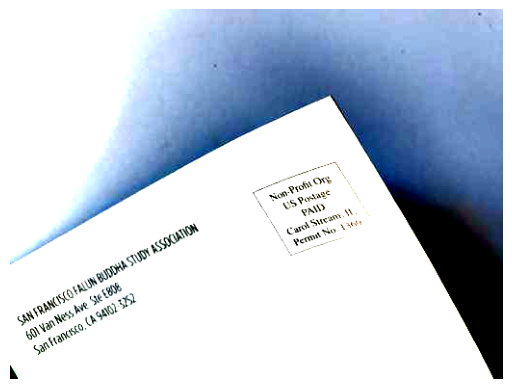

class: glass predicted: glass


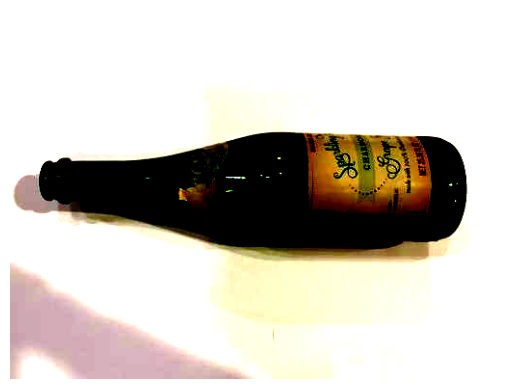

class: cardboard predicted: cardboard


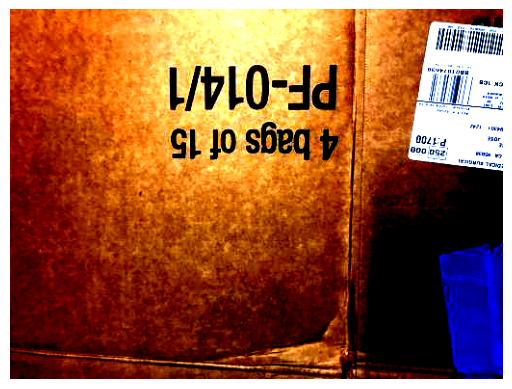

class: cardboard predicted: cardboard


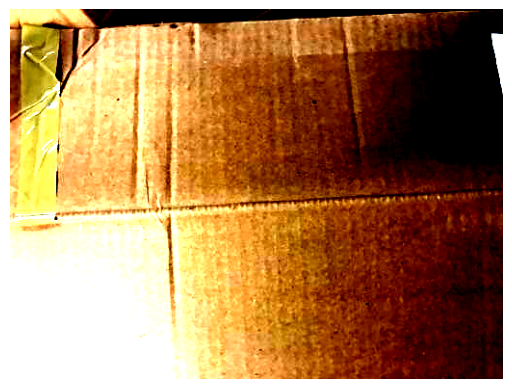

class: paper predicted: paper


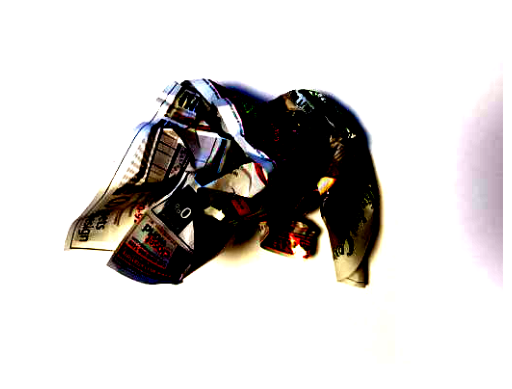

class: plastic predicted: plastic


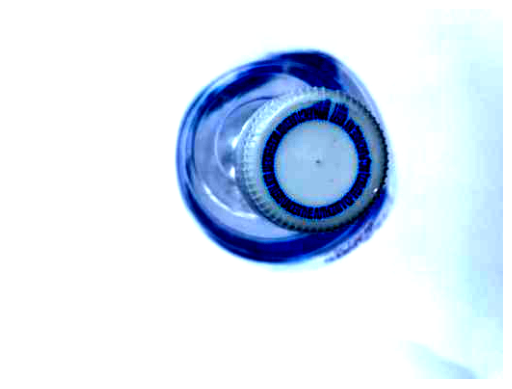

class: glass predicted: glass


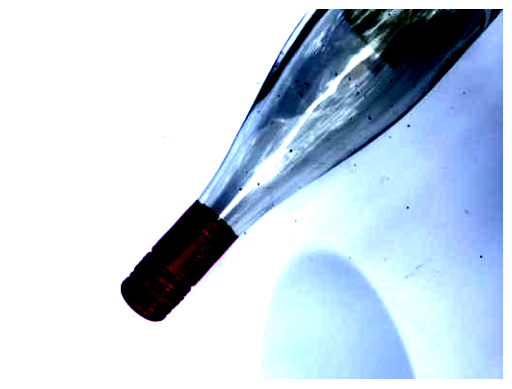

class: trash predicted: trash


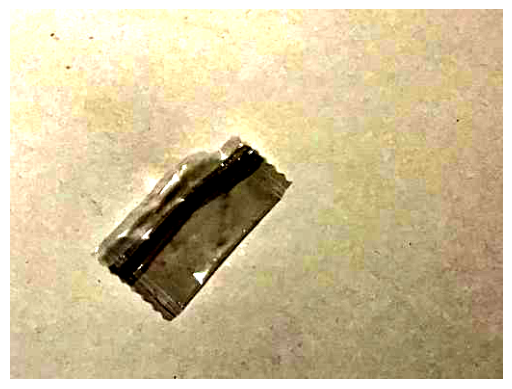

In [ ]:
visualize_model(model)

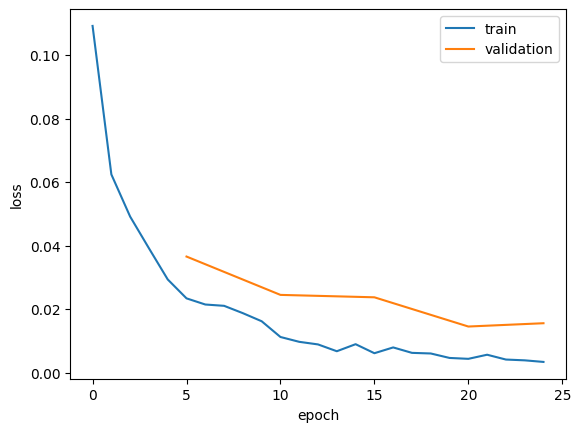

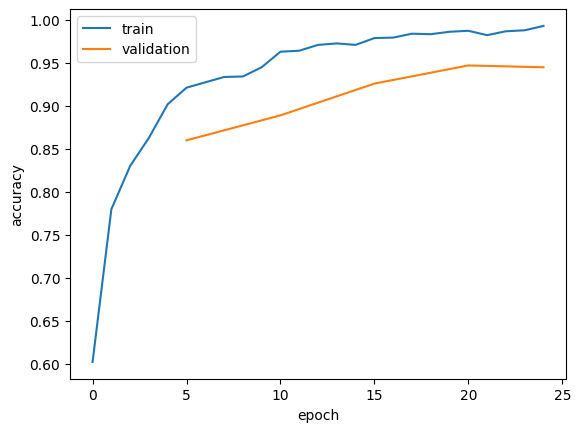

In [ ]:
from scipy import interpolate
x = np.arange(5, 25)
x_train = np.arange(0,25)
x1 = [5, 10, 15, 20, 25]
f_loss = interpolate.interp1d(x1, val_loss_list)
f_accuracy = interpolate.interp1d(x1, val_acc_list)


val_acc = f_accuracy(x)   # use interpolation function returned by `interp1d`
val_loss = f_loss(x)

train_loss_list
train_acc_list
val_loss
val_acc


plt.plot(x_train, train_loss_list)
plt.plot(x, val_loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()
plt.figure()
plt.plot(x_train, train_acc_list)
plt.plot(x, val_acc)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

def test_single_image(model, image_path, class_names):
    transform = transforms.Compose([
        transforms.Resize(384),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add a batch dimension

    if torch.cuda.is_available():
        model = model.cuda()
        image = image.cuda()

    # Pass the image through the model
    model.eval()
    with torch.no_grad():
        outputs = model(image)

    _, predicted = torch.max(outputs, 1)
    class_index = predicted.item()
    class_label = class_names[class_index]

    return class_label

# Example usage
model_test =model  # Your trained model
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']  # List of class names
image_path = "/content/drive/MyDrive/dataset-resized/cardboard/cardboard150.jpg"

predicted_class = test_single_image(model, image_path, class_names)
print("Predicted class:", predicted_class)


Predicted class: cardboard


In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.1/288.1 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 

In [ ]:
import pickle

# Save the trained model to a file
model_path = '/content/drive/MyDrive/model.pkl'
with open(model_path, 'wb') as f:
    torch.save(model, model_path)


In [ ]:
import requests
from PIL import Image
from torchvision import transforms
def predict(model, image_path, class_names):
    transform = transforms.Compose([
        transforms.Resize(384),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add a batch dimension

    if torch.cuda.is_available():
        model = model.cuda()
        image = image.cuda()

    # Pass the image through the model
    model.eval()
    with torch.no_grad():
        outputs = model(image)

    _, predicted = torch.max(outputs, 1)
    class_index = predicted.item()
    class_label = class_names[class_index]

    return class_label

In [ ]:
import gradio as gr

gr.Interface(fn=predict,
             inputs=gr.Image(type="pil"),
             outputs=gr.Label(num_top_classes=3),
             examples=["lion.jpg", "cheetah.jpg"]).launch()
